In [1]:
import time
import random
import numpy as np
import sys
import pickle
import h5py
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from functions.fftc import fft2c_new as fft2c
from functions.fftc import ifft2c_new as ifft2c
from functions.math import complex_abs, complex_mul, complex_conj
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_sens_TTT, complex_center_crop, center_crop_to_smallest
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss
from functions.helper import evaluate2c_imagepair
### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/cheng/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/cheng/bart-0.7.00/"
import bart

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


### Load the data

In [2]:
# data path
path_train = '/cheng/metaMRI/metaMRI/data_dict_temp/brain_train_test.yaml'

# mask function and data transform
mask_function = create_mask_for_mask_type(mask_type_str = 'random', self_sup = False, 
                    center_fraction = 0.08, acceleration = 4.0, acceleration_total = 3.0)

data_transform = UnetDataTransform_sens_TTT('multicoil', mask_func = mask_function, use_seed=True, mode='adapt')

# training dataset and data loader
testset = SliceDataset(dataset = path_train, path_to_dataset='', 
                path_to_sensmaps='/cheng/metaMRI/metaMRI/data_sensmaps/', 
                provide_senmaps=True, 
                challenge="multicoil", 
                transform=data_transform, 
                use_dataset_cache=True)
test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, 
                shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)


In [5]:
batch = next(iter(test_dataloader))
input_image, target_image, ground_truth_image, mean, std, fname, slice_num, input_kspace, input_mask, target_kspace, target_mask, sens_maps, binary_background_mask = batch

### Load the model

In [14]:
# '/cheng/metaMRI/metaMRI/save/E11.1_maml(L1-10adapt)_T300_200epoch/E11.1_maml(L1-10adapt)_T300_200epoch_E79_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.2_maml(L1-5adapt)_T300_200epoch/E11.2_maml(L1-5adapt)_T300_200epoch_E54_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.1_self(l1-1e-3)_T300_100epoch/E11.1_self(l1-1e-3)_T300_100epoch_E88_best.pth'

# '/cheng/metaMRI/metaMRI/save/E11.1_self(l1-1e-5)_T300_200epoch/E11.1_self(l1-1e-5)_T300_200epoch_E105_best.pth'

checkpoint_path_meta = '/cheng/metaMRI/metaMRI/save/E11.2_maml(L1-5adapt)_T300_200epoch/E11.2_maml(L1-5adapt)_T300_200epoch_E116_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.2_maml(l1_CA-1e-3-4_P)_T300_200epoch/E11.2_maml(l1_CA-1e-3-4_P)_T300_200epoch_E79_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.2_maml(L1-10adapt)_T300_200epoch/E11.2_maml(L1-10adapt)_T300_200epoch_E79_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.1_maml(L1-5adapt)_T300_200epoch/E11.1_maml(L1-5adapt)_T300_200epoch_E79_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.1_maml(L1-10adapt)_T300_200epoch/E11.1_maml(L1-10adapt)_T300_200epoch_E104_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.2_maml(L1-5adapt)_T300_200epoch/E11.2_maml(L1-5adapt)_T300_200epoch_E116_best.pth'

model_meta = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
model_meta.load_state_dict(torch.load(checkpoint_path_meta))
model_meta = model_meta.to(device)

checkpoint_path_self = '/cheng/metaMRI/metaMRI/save/E11.2_joint(l1_CA-1e-3-4_P)_T300_120epoch/E11.2_joint(l1_CA-1e-3-4_P)_T300_120epoch_E75_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.1_self(l1-1e-3)_T300_100epoch/E11.1_self(l1-1e-3)_T300_100epoch_E88_best.pth'
model_self = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
model_self.load_state_dict(torch.load(checkpoint_path_self))
model_self = model_self.to(device)




### Inference without test-time training

In [3]:
checkpoint_Q_path = '/cheng/metaMRI/metaMRI/save/E11.2_sup(l1_CA-1e-3-4_Q)_T300_1200epoch/E11.2_sup(l1_CA-1e-3-4_Q)_T300_1200epoch_E98_best.pth'
model = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_Q_path))
model = model.to(device)

In [6]:
l1_loss, nmse_loss, psnr_loss, ssim_loss, output_image, output_image_1c = evaluate2c_imagepair(model, input_image, target_image, mean, std, ground_truth_image)
print('L1_loss: ', l1_loss)
print('NMSE: ', nmse_loss)
print('PSNR: ', psnr_loss)
print('SSIM: ', ssim_loss)

Inference time:  1.1278326511383057
L1_loss:  0.15335194766521454
NMSE:  0.02623957209289074
PSNR:  30.111976623535156
SSIM:  0.8926400542259216


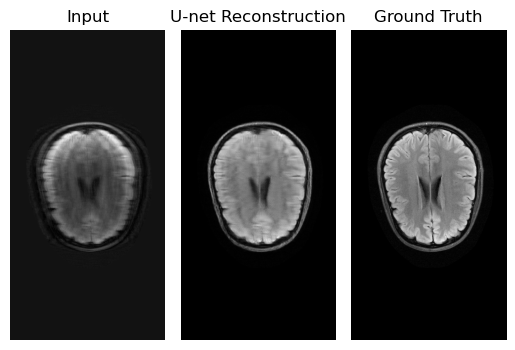

In [7]:
input_image_plot = complex_abs(torch.moveaxis(((input_image - mean)/std) , 1, -1 )).squeeze(0).squeeze(0).cpu().detach().numpy()

fig, axes = plt.subplots(1, 3)

axes[0].imshow(input_image_plot,cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(output_image_1c.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('U-net Reconstruction')
axes[1].axis('off')

axes[2].imshow(ground_truth_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()

### Inference with test-time training

In [5]:
TTT_EPOCH = 200
model = model_self
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
l1_loss = torch.nn.L1Loss(reduction='sum')
train_inputs = input_image.to(device)
input_kspace = input_kspace.to(device)
input_mask = input_mask.to(device)
sens_maps = sens_maps.to(device)
std = std.to(device)
mean = mean.to(device)

for iteration in range(TTT_EPOCH):
    train_outputs = model(train_inputs)
    train_outputs = train_outputs * std + mean
    train_outputs = torch.moveaxis(train_outputs, 1, -1 )
    sens_maps = sens_maps.to(device)
    output_sens_image = complex_mul(train_outputs, sens_maps)
    Fimg = fft2c(output_sens_image)
    Fimg_forward = Fimg * input_mask
    loss_self = l1_loss(Fimg_forward, input_kspace) / torch.sum(torch.abs(input_kspace))

    optimizer.zero_grad()
    loss_self.backward()
    optimizer.step()

In [19]:
l1_loss, nmse_loss, psnr_loss, ssim_loss, output_image, output_image_1c = evaluate2c_imagepair(model, input_image, target_image, mean, std, ground_truth_image)
print('L1_loss: ', l1_loss)
print('NMSE: ', nmse_loss)
print('PSNR: ', psnr_loss)
print('SSIM: ', ssim_loss)

Inference time:  0.008770942687988281
L1_loss:  0.11420031636953354
NMSE:  0.009852834977209568
PSNR:  34.355926513671875
SSIM:  0.9270870685577393


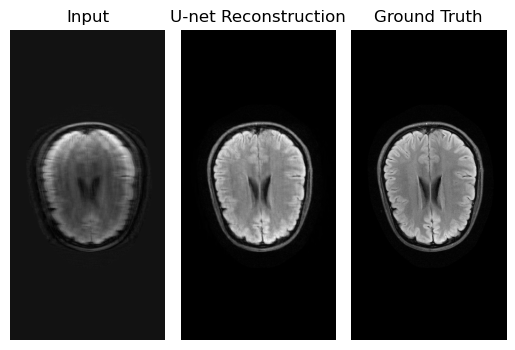

In [21]:
input_image = input_image.to(device)
input_image_plot = complex_abs(torch.moveaxis(((input_image - mean)/std) , 1, -1 )).squeeze(0).squeeze(0).cpu().detach().numpy()

fig, axes = plt.subplots(1, 3)

axes[0].imshow(input_image_plot,cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(output_image_1c.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('U-net Reconstruction')
axes[1].axis('off')

axes[2].imshow(ground_truth_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()

Plot

In [12]:
TTT_EPOCH = 1000

l1_loss = torch.nn.L1Loss(reduction='sum')
ssim_fct = SSIMLoss()

train_inputs = input_image.to(device)
train_targets = target_image.to(device)
input_kspace = input_kspace.to(device)
input_mask = input_mask.to(device)
sens_maps = sens_maps.to(device)
std = std.to(device)
mean = mean.to(device)
ground_truth_image = ground_truth_image.to(device)
binary_background_mask = binary_background_mask.to(device)

def TTT(model, TTT_EPOCH, adapt_lr): 
    optimizer = torch.optim.Adam(model.parameters(),lr=adapt_lr)
    loss_l1_history = []
    loss_ssim_history = []
    self_loss_history = []

    for iteration in range(TTT_EPOCH):
        # fθ(A†y)
        train_outputs = model(train_inputs)
        train_outputs = train_outputs * std + mean
        # supervised loss [x, fθ(A†y)]
        # L1
        loss_l1 = (l1_loss(train_outputs, train_targets) / torch.sum(torch.abs(train_targets))).item()
        #print('Test L1 loss: ',loss_l1)
        loss_l1_history.append(loss_l1)
        # SSIM = 1 - loss
        output_image_1c = complex_abs(torch.moveaxis(train_outputs , 1, -1 ))
        loss_ssim = 1 - ssim_fct(output_image_1c, ground_truth_image, data_range = ground_truth_image.max().unsqueeze(0)).item()
        #print('Test SSIM loss: ',loss_ssim)
        loss_ssim_history.append(loss_ssim)

        # self-supervised loss
        # fθ(A†y)
        train_outputs = torch.moveaxis(train_outputs, 1, -1 )
        # S fθ(A†y)
        output_sens_image = complex_mul(train_outputs, sens_maps)
        # FS fθ(A†y)
        Fimg = fft2c(output_sens_image)
        # MFS fθ(A†y) = A fθ(A†y)
        Fimg_forward = Fimg * input_mask
        # self-supervised loss [y, Afθ(A†y)]
        loss_self = l1_loss(Fimg_forward, input_kspace) / torch.sum(torch.abs(input_kspace))

        optimizer.zero_grad()
        loss_self.backward()
        optimizer.step()
        #train_loss += loss.item()
        #print('TTT loss: ',loss_self.item())
        self_loss_history.append(loss_self.item())

    return loss_l1_history, loss_ssim_history, self_loss_history

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

colors = ['b','r','k','g','m','c','tab:brown','tab:orange','tab:pink','tab:gray','tab:olive','tab:purple']

markers = ["v","o","^","1","*",">","d","<","s","P","X"]
FONTSIZE = 22

MAML 10 adapt step: inner self, outer sup

Self-supervised training best epoch:  250
Meta self-supervised training best epoch:  266


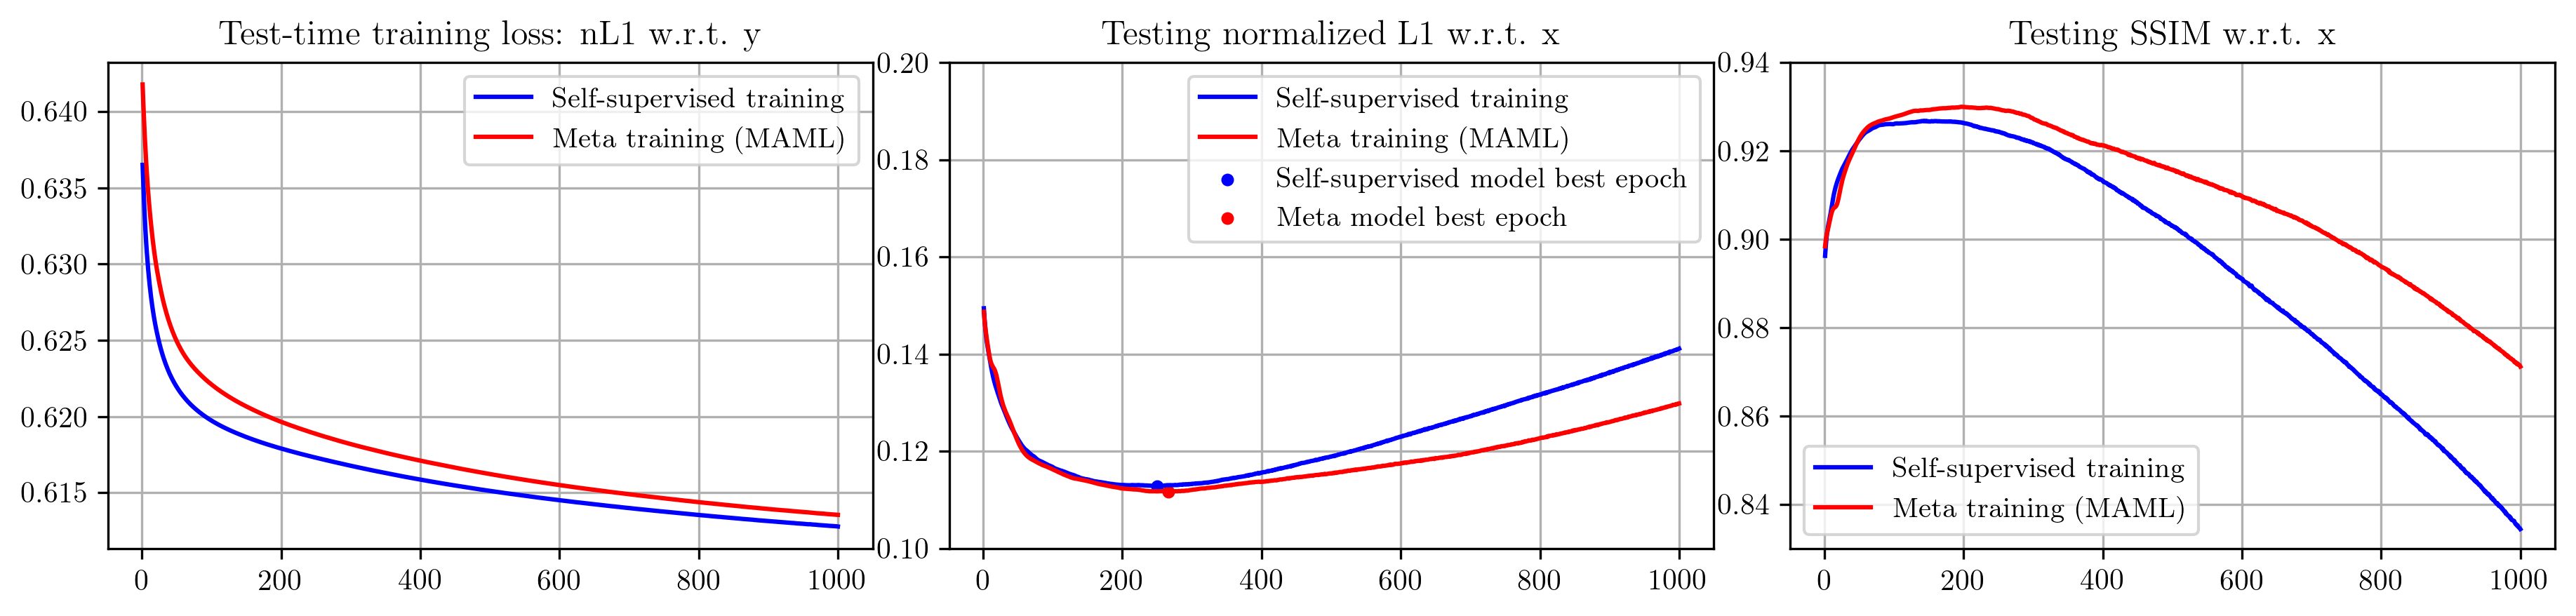

In [15]:
loss_l1_history, loss_ssim_history, self_loss_history = TTT(model_self, TTT_EPOCH)
min_index = np.argmin(loss_l1_history)
print('Self-supervised training best epoch: ',min_index)

meta_loss_l1_history, meta_loss_ssim_history, meta_self_loss_history = TTT(model_meta, TTT_EPOCH)
meta_min_index = np.argmin(meta_loss_l1_history)
print('Meta self-supervised training best epoch: ',meta_min_index)

fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300)
axes[0].plot(range(1, TTT_EPOCH+1), self_loss_history, color=colors[0], label='Self-supervised training')
axes[0].plot(range(1, TTT_EPOCH+1), meta_self_loss_history, color=colors[1], label='Meta training (MAML)')
axes[0].set_title('Test-time training loss: nL1 w.r.t. y')
axes[0].legend(fontsize = (FONTSIZE-3)/2)
axes[0].grid(True)

axes[1].plot(range(1, TTT_EPOCH+1), loss_l1_history, color=colors[0], label='Self-supervised training')
axes[1].plot(range(1, TTT_EPOCH+1), meta_loss_l1_history, color=colors[1], label='Meta training (MAML)')
axes[1].scatter(min_index, loss_l1_history[min_index], color=colors[0], s=FONTSIZE/2, label = 'Self-supervised model best epoch')
axes[1].scatter(meta_min_index, meta_loss_l1_history[meta_min_index], color=colors[1], s=FONTSIZE/2, label = 'Meta model best epoch')
axes[1].set_title('Testing normalized L1 w.r.t. x')
axes[1].set_ylim(0.10, 0.20)
axes[1].legend(fontsize = (FONTSIZE-3)/2)
axes[1].grid(True)

axes[2].plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='Self-supervised training')
axes[2].plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta training (MAML)')
axes[2].set_title('Testing SSIM w.r.t. x')
axes[2].set_ylim(0.83, 0.94)
axes[2].legend(fontsize = (FONTSIZE-3)/2)
axes[2].grid(True)

plt.subplots_adjust(wspace=0.1)
#plt.legend(fontsize = (FONTSIZE-3)/2)
plt.show()

MAML 5 adapt step: inner self, outer sup

Self-supervised training best epoch:  251
Meta self-supervised training best epoch:  284


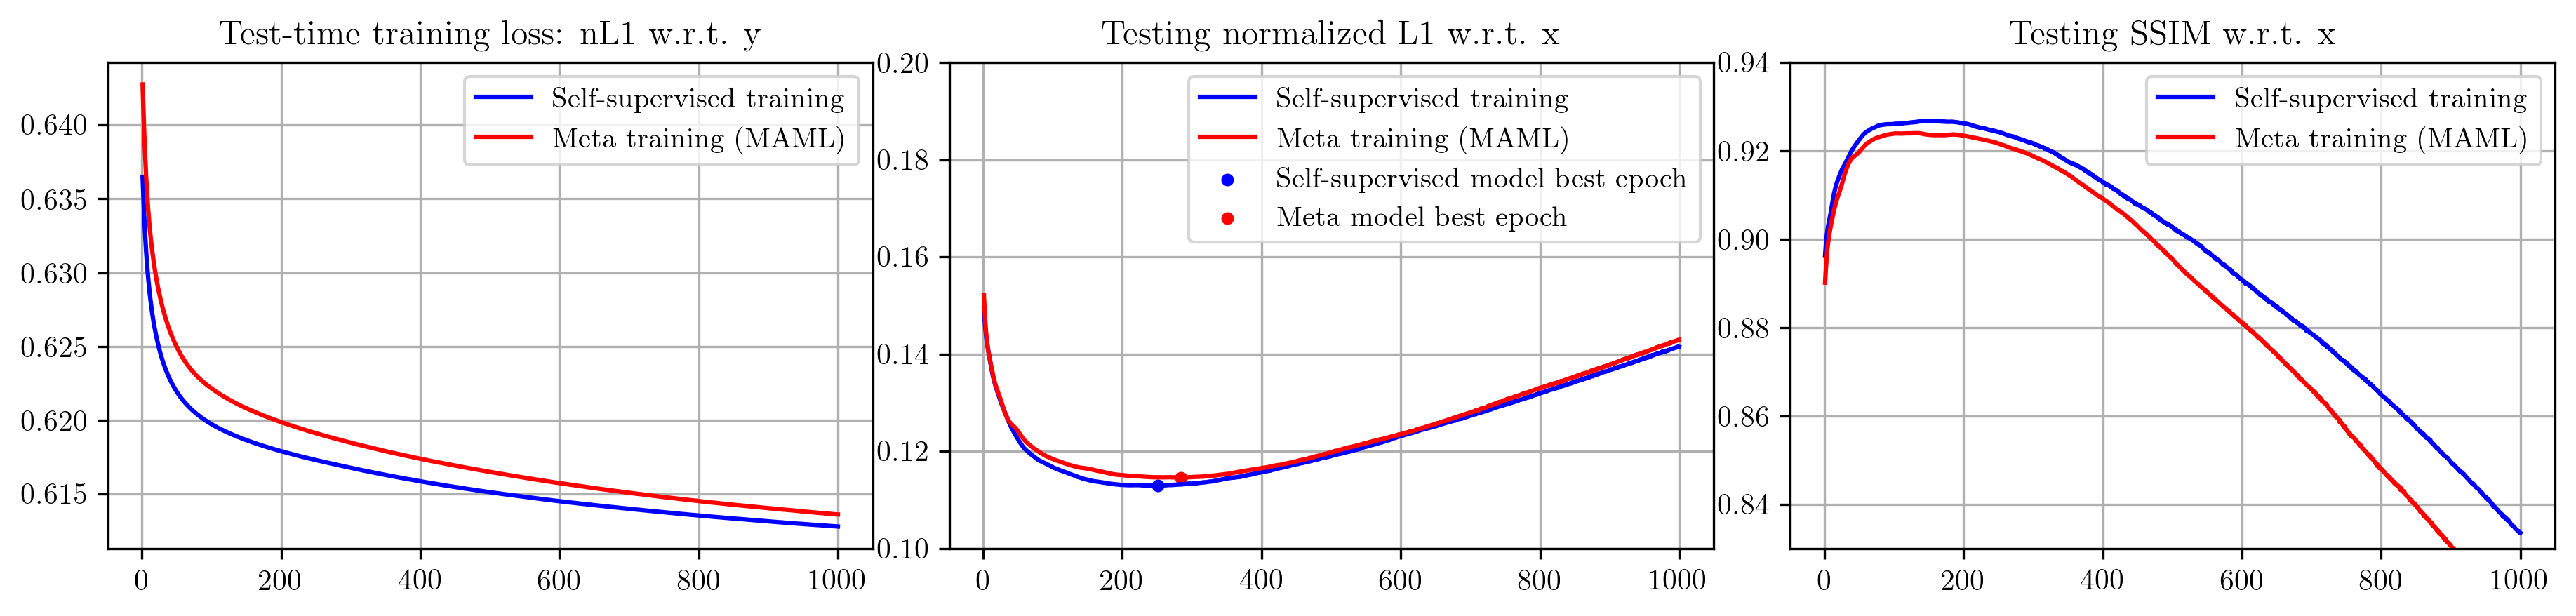

In [13]:
loss_l1_history, loss_ssim_history, self_loss_history = TTT(model_self, TTT_EPOCH)
min_index = np.argmin(loss_l1_history)
print('Self-supervised training best epoch: ',min_index)

meta_loss_l1_history, meta_loss_ssim_history, meta_self_loss_history = TTT(model_meta, TTT_EPOCH)
meta_min_index = np.argmin(meta_loss_l1_history)
print('Meta self-supervised training best epoch: ',meta_min_index)

fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300)
axes[0].plot(range(1, TTT_EPOCH+1), self_loss_history, color=colors[0], label='Self-supervised training')
axes[0].plot(range(1, TTT_EPOCH+1), meta_self_loss_history, color=colors[1], label='Meta training (MAML)')
axes[0].set_title('Test-time training loss: nL1 w.r.t. y')
axes[0].legend(fontsize = (FONTSIZE-3)/2)
axes[0].grid(True)

axes[1].plot(range(1, TTT_EPOCH+1), loss_l1_history, color=colors[0], label='Self-supervised training')
axes[1].plot(range(1, TTT_EPOCH+1), meta_loss_l1_history, color=colors[1], label='Meta training (MAML)')
axes[1].scatter(min_index, loss_l1_history[min_index], color=colors[0], s=FONTSIZE/2, label = 'Self-supervised model best epoch')
axes[1].scatter(meta_min_index, meta_loss_l1_history[meta_min_index], color=colors[1], s=FONTSIZE/2, label = 'Meta model best epoch')
axes[1].set_title('Testing normalized L1 w.r.t. x')
axes[1].set_ylim(0.10, 0.20)
axes[1].legend(fontsize = (FONTSIZE-3)/2)
axes[1].grid(True)

axes[2].plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='Self-supervised training')
axes[2].plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta training (MAML)')
axes[2].set_title('Testing SSIM w.r.t. x')
axes[2].set_ylim(0.83, 0.94)
axes[2].legend(fontsize = (FONTSIZE-3)/2)
axes[2].grid(True)

plt.subplots_adjust(wspace=0.1)
#plt.legend(fontsize = (FONTSIZE-3)/2)
plt.show()

MAML 5 adapt step: inner self, outer joint

In [31]:
loss_l1_history_, loss_ssim_history_, self_loss_history_ = TTT(model_self, TTT_EPOCH, adapt_lr=0.001)
min_index_ = np.argmin(loss_l1_history_)
print('Self-supervised training best epoch: ',min_index_)

Self-supervised training best epoch:  76


In [33]:
loss_ssim_history_[max_index1]

0.9276513457298279

In [34]:
meta_loss_ssim_history[max_index2]

0.9293796420097351

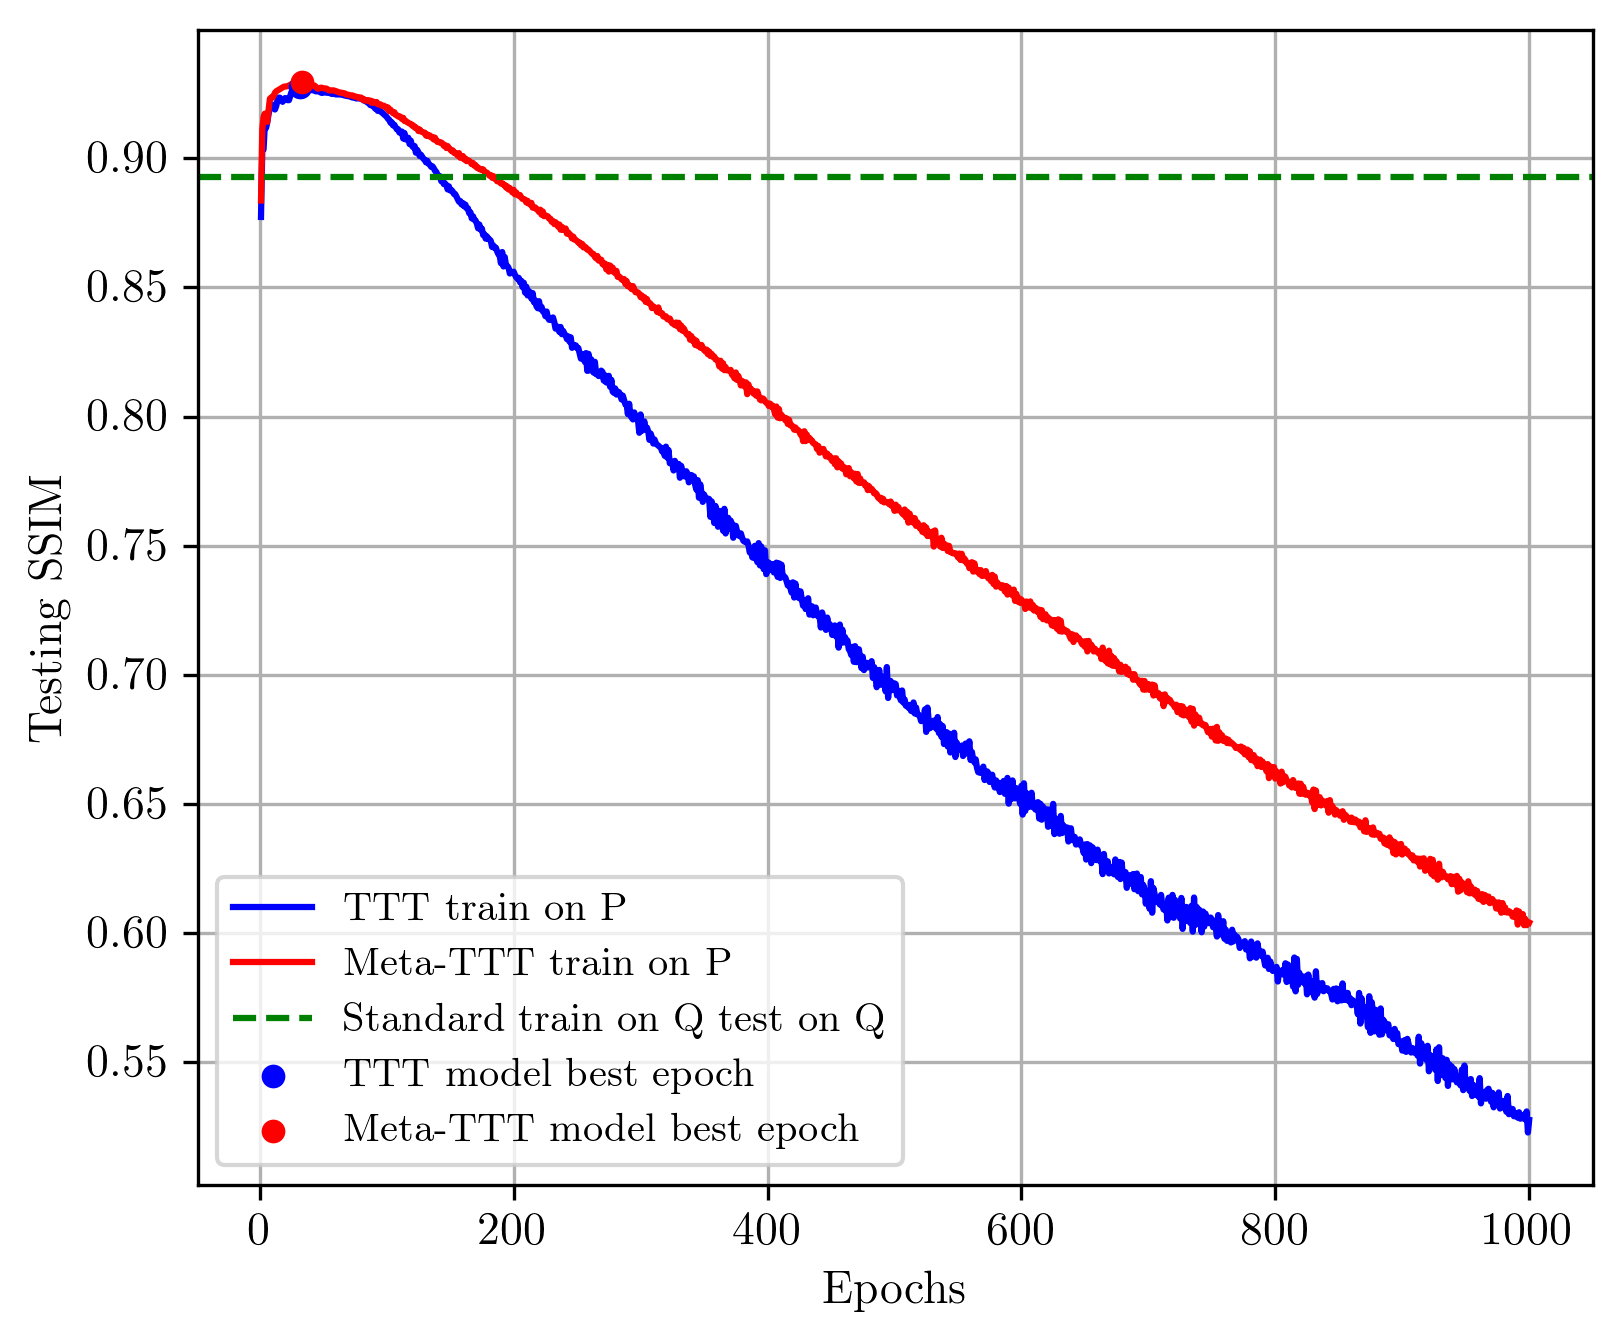

In [32]:
upper_bound = 0.8926

max_index2 = np.argmax(meta_loss_ssim_history)
max_index1 = np.argmax(loss_ssim_history_)

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_EPOCH+1), loss_ssim_history_, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])

plt.scatter(max_index1, loss_ssim_history_[max_index1], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(max_index2, meta_loss_ssim_history[max_index2], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

Self-supervised training best epoch:  183
Meta self-supervised training best epoch:  154


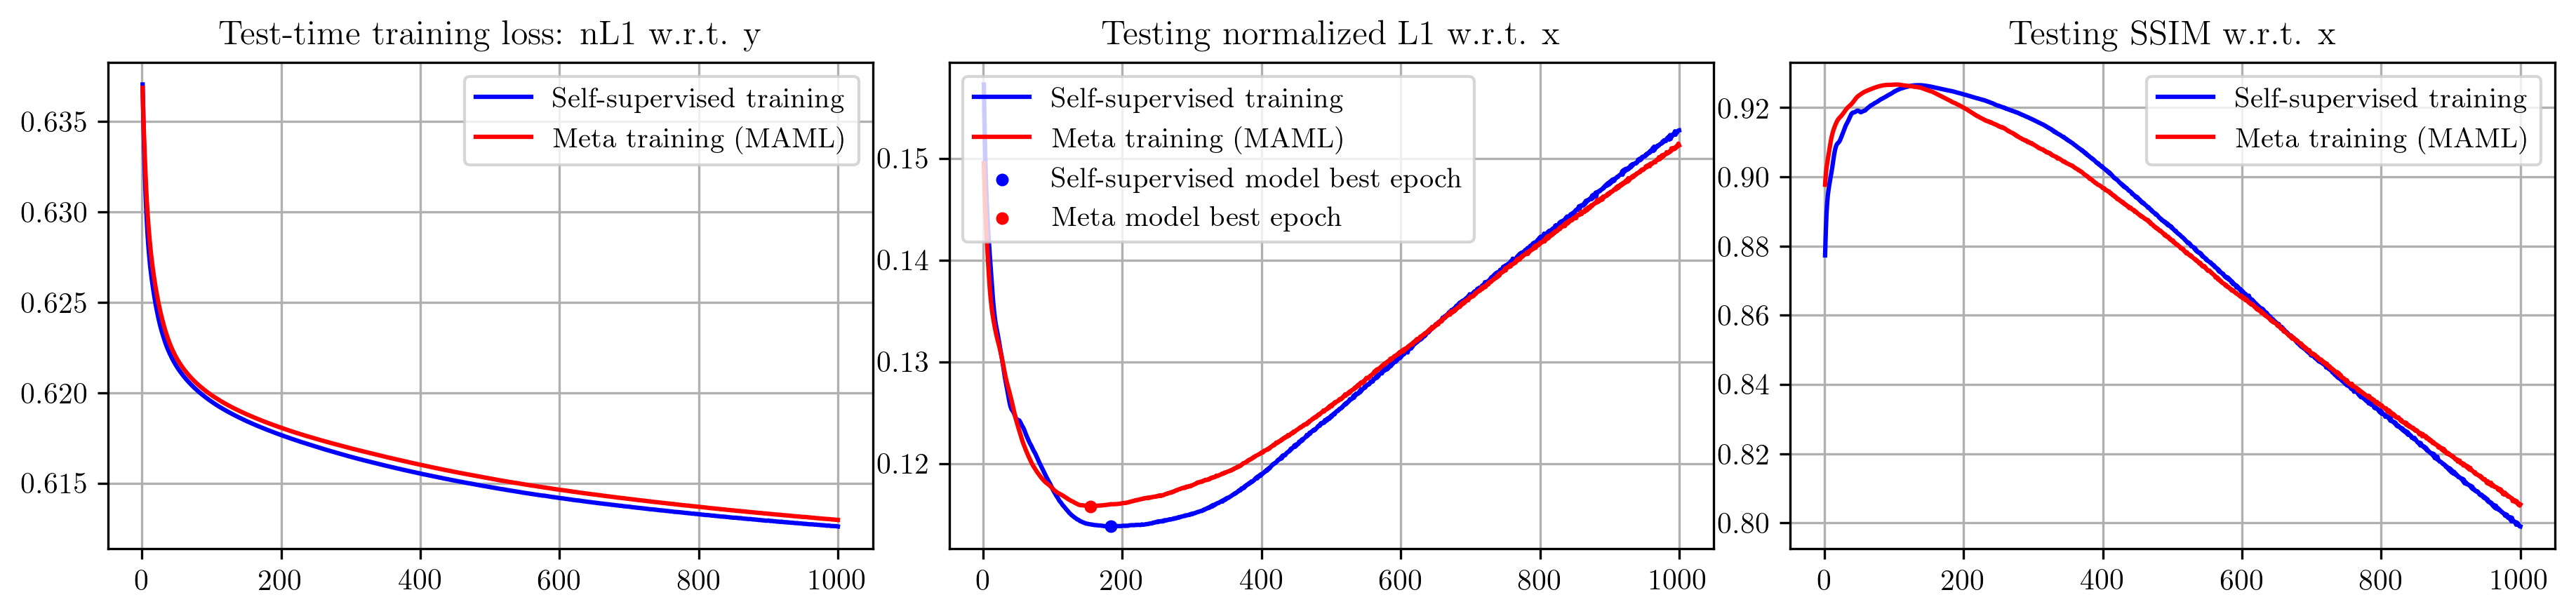

In [11]:
loss_l1_history, loss_ssim_history, self_loss_history = TTT(model_self, TTT_EPOCH)
min_index = np.argmin(loss_l1_history)
print('Self-supervised training best epoch: ',min_index)

meta_loss_l1_history, meta_loss_ssim_history, meta_self_loss_history = TTT(model_meta, TTT_EPOCH)
meta_min_index = np.argmin(meta_loss_l1_history)
print('Meta self-supervised training best epoch: ',meta_min_index)

fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300)
axes[0].plot(range(1, TTT_EPOCH+1), self_loss_history, color=colors[0], label='Self-supervised training')
axes[0].plot(range(1, TTT_EPOCH+1), meta_self_loss_history, color=colors[1], label='Meta training (MAML)')
axes[0].set_title('Test-time training loss: nL1 w.r.t. y')
axes[0].legend(fontsize = (FONTSIZE-3)/2)
axes[0].grid(True)

axes[1].plot(range(1, TTT_EPOCH+1), loss_l1_history, color=colors[0], label='Self-supervised training')
axes[1].plot(range(1, TTT_EPOCH+1), meta_loss_l1_history, color=colors[1], label='Meta training (MAML)')
axes[1].scatter(min_index, loss_l1_history[min_index], color=colors[0], s=FONTSIZE/2, label = 'Self-supervised model best epoch')
axes[1].scatter(meta_min_index, meta_loss_l1_history[meta_min_index], color=colors[1], s=FONTSIZE/2, label = 'Meta model best epoch')
axes[1].set_title('Testing normalized L1 w.r.t. x')
# axes[1].set_ylim(0.10, 0.20)
axes[1].legend(fontsize = (FONTSIZE-3)/2)
axes[1].grid(True)

axes[2].plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='Self-supervised training')
axes[2].plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta training (MAML)')
axes[2].set_title('Testing SSIM w.r.t. x')
# axes[2].set_ylim(0.83, 0.94)
axes[2].legend(fontsize = (FONTSIZE-3)/2)
axes[2].grid(True)

plt.subplots_adjust(wspace=0.1)
#plt.legend(fontsize = (FONTSIZE-3)/2)
plt.show()

Meta self-supervised training best epoch:  79


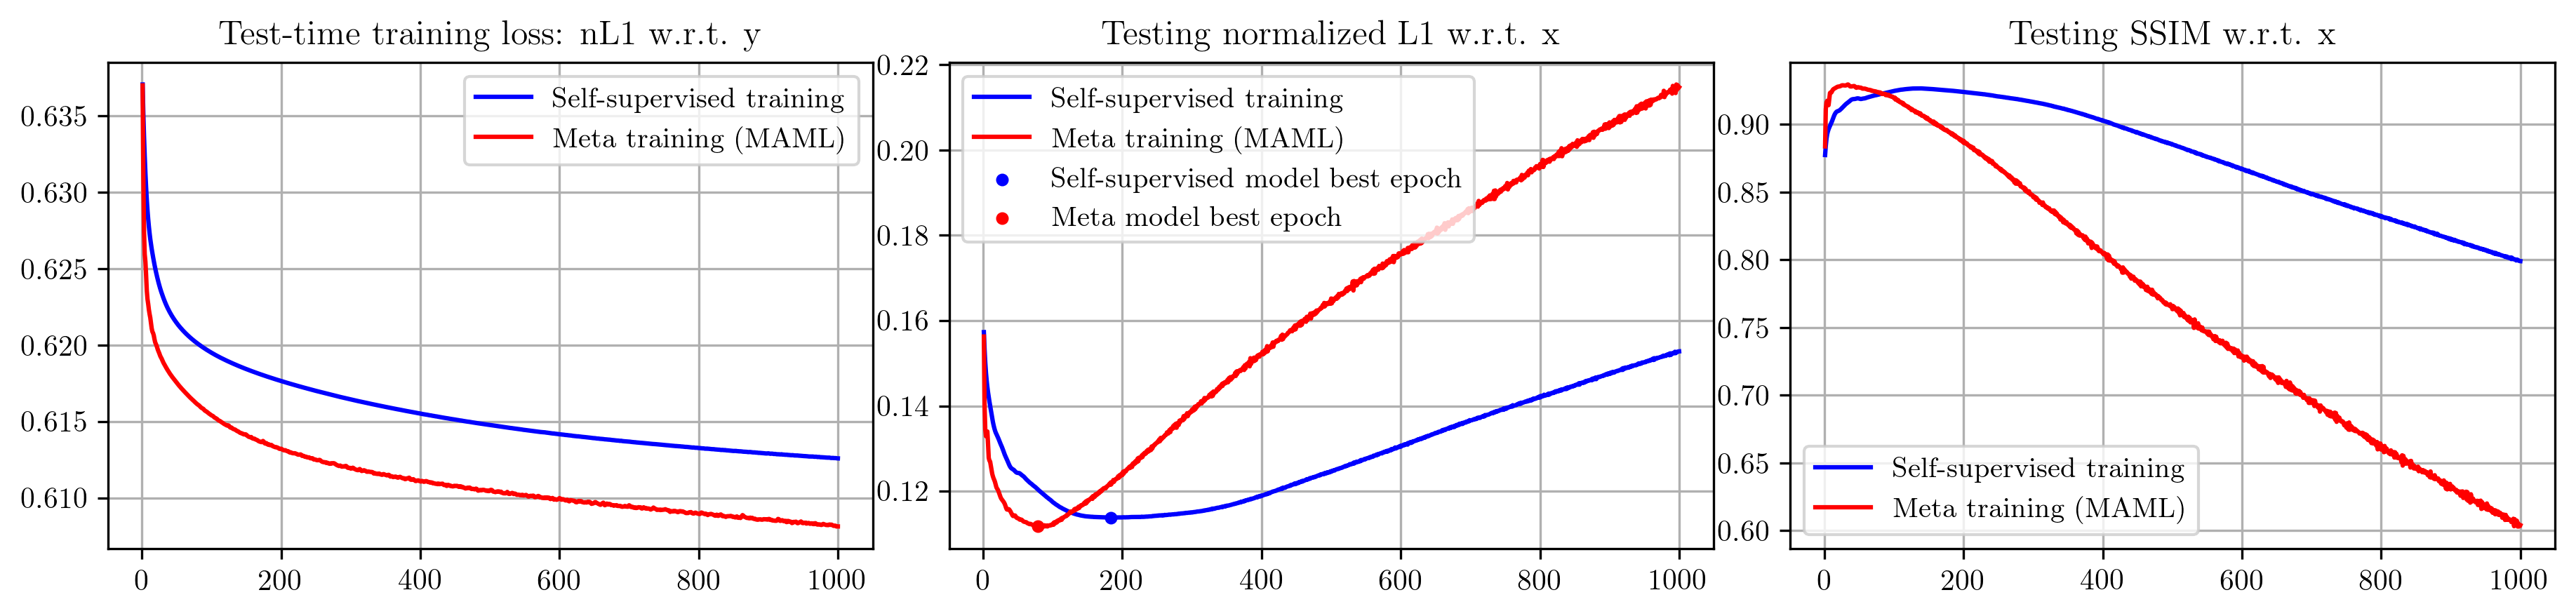

In [15]:
meta_loss_l1_history, meta_loss_ssim_history, meta_self_loss_history = TTT(model_meta, TTT_EPOCH, adapt_lr=0.001)
meta_min_index = np.argmin(meta_loss_l1_history)
print('Meta self-supervised training best epoch: ',meta_min_index)

fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300)
axes[0].plot(range(1, TTT_EPOCH+1), self_loss_history, color=colors[0], label='Self-supervised training')
axes[0].plot(range(1, TTT_EPOCH+1), meta_self_loss_history, color=colors[1], label='Meta training (MAML)')
axes[0].set_title('Test-time training loss: nL1 w.r.t. y')
axes[0].legend(fontsize = (FONTSIZE-3)/2)
axes[0].grid(True)

axes[1].plot(range(1, TTT_EPOCH+1), loss_l1_history, color=colors[0], label='Self-supervised training')
axes[1].plot(range(1, TTT_EPOCH+1), meta_loss_l1_history, color=colors[1], label='Meta training (MAML)')
axes[1].scatter(min_index, loss_l1_history[min_index], color=colors[0], s=FONTSIZE/2, label = 'Self-supervised model best epoch')
axes[1].scatter(meta_min_index, meta_loss_l1_history[meta_min_index], color=colors[1], s=FONTSIZE/2, label = 'Meta model best epoch')
axes[1].set_title('Testing normalized L1 w.r.t. x')
# axes[1].set_ylim(0.10, 0.20)
axes[1].legend(fontsize = (FONTSIZE-3)/2)
axes[1].grid(True)

axes[2].plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='Self-supervised training')
axes[2].plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta training (MAML)')
axes[2].set_title('Testing SSIM w.r.t. x')
# axes[2].set_ylim(0.83, 0.94)
axes[2].legend(fontsize = (FONTSIZE-3)/2)
axes[2].grid(True)

plt.subplots_adjust(wspace=0.1)
#plt.legend(fontsize = (FONTSIZE-3)/2)
plt.show()

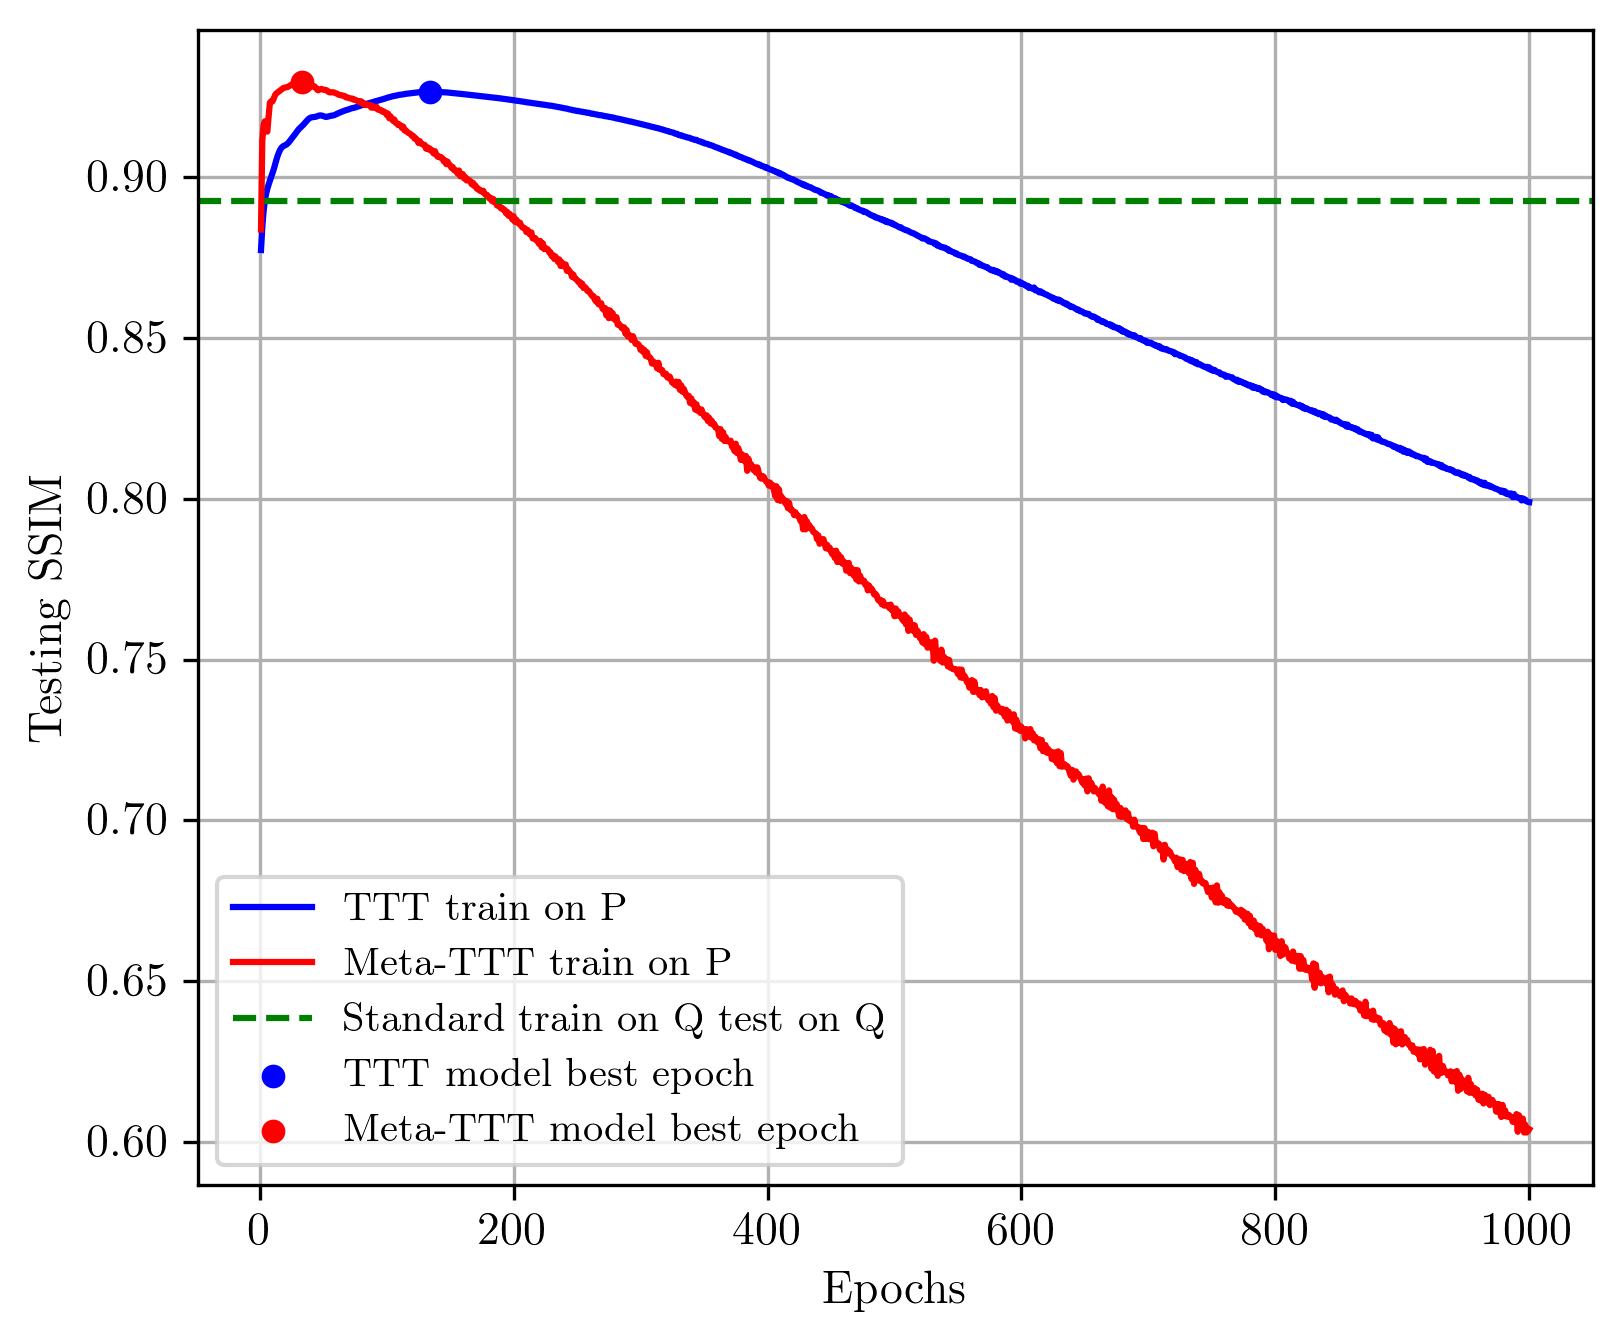

In [30]:
upper_bound = 0.8926

max_index2 = np.argmax(meta_loss_ssim_history)
max_index1 = np.argmax(loss_ssim_history)

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])

plt.scatter(max_index1, loss_ssim_history[max_index1], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(max_index2, meta_loss_ssim_history[max_index2], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

MAML 10 adapt step: inner self, outer joint

Self-supervised training best epoch:  247
Meta self-supervised training best epoch:  291


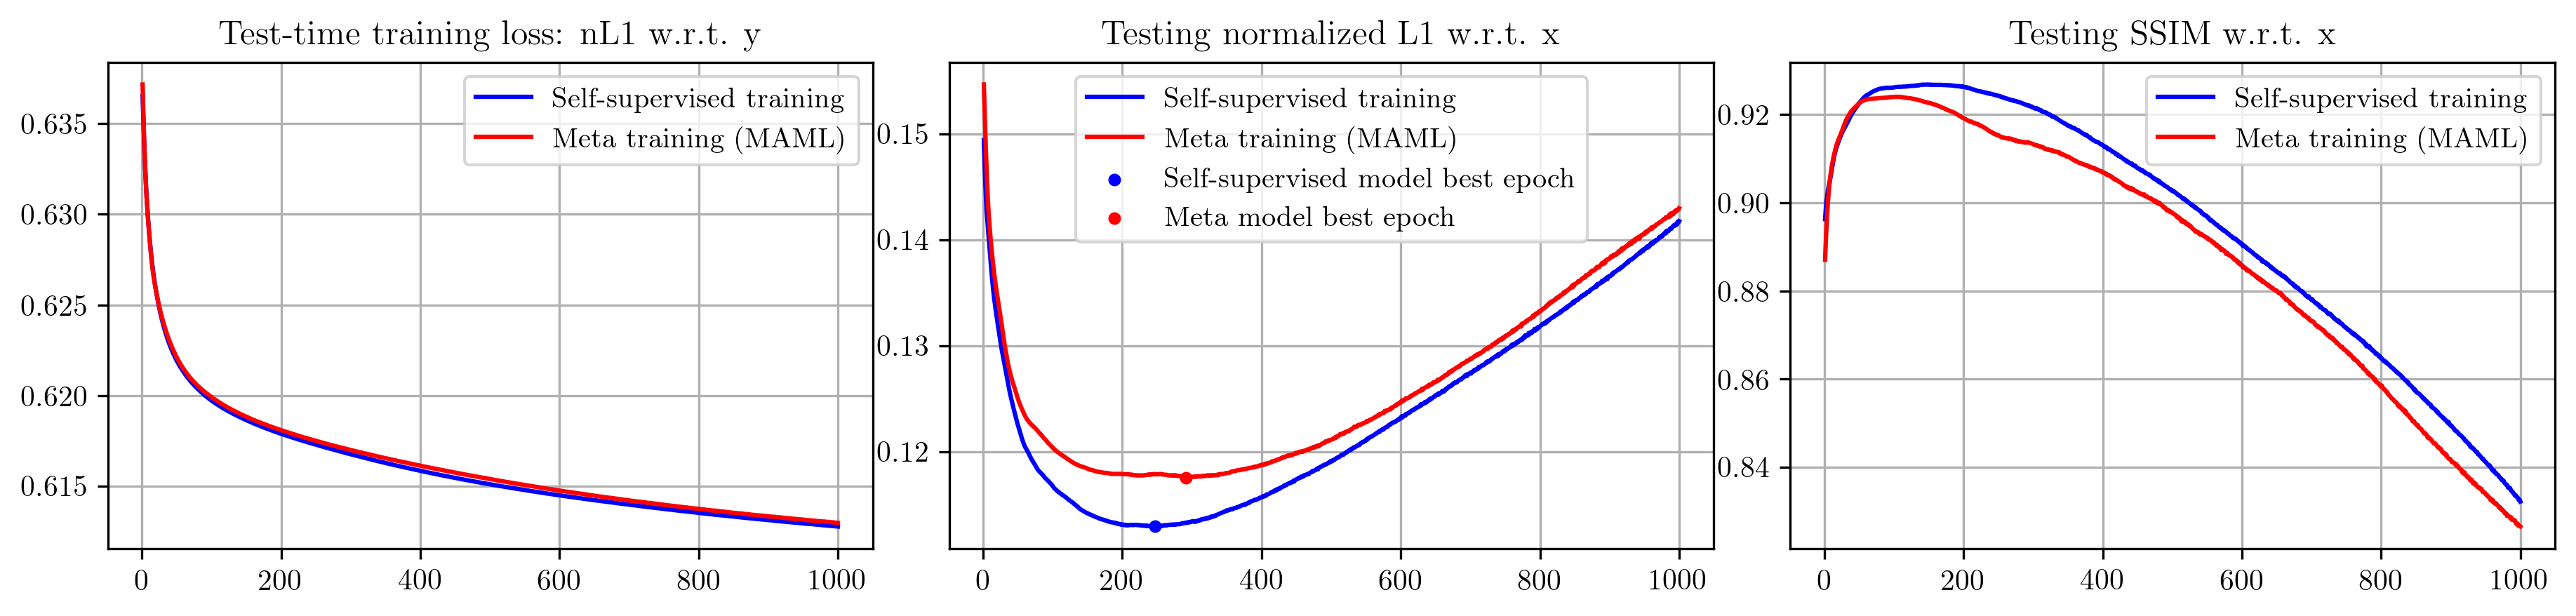

In [7]:
loss_l1_history, loss_ssim_history, self_loss_history = TTT(model_self, TTT_EPOCH)
min_index = np.argmin(loss_l1_history)
print('Self-supervised training best epoch: ',min_index)

meta_loss_l1_history, meta_loss_ssim_history, meta_self_loss_history = TTT(model_meta, TTT_EPOCH)
meta_min_index = np.argmin(meta_loss_l1_history)
print('Meta self-supervised training best epoch: ',meta_min_index)

fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300)
axes[0].plot(range(1, TTT_EPOCH+1), self_loss_history, color=colors[0], label='Self-supervised training')
axes[0].plot(range(1, TTT_EPOCH+1), meta_self_loss_history, color=colors[1], label='Meta training (MAML)')
axes[0].set_title('Test-time training loss: nL1 w.r.t. y')
axes[0].legend(fontsize = (FONTSIZE-3)/2)
axes[0].grid(True)

axes[1].plot(range(1, TTT_EPOCH+1), loss_l1_history, color=colors[0], label='Self-supervised training')
axes[1].plot(range(1, TTT_EPOCH+1), meta_loss_l1_history, color=colors[1], label='Meta training (MAML)')
axes[1].scatter(min_index, loss_l1_history[min_index], color=colors[0], s=FONTSIZE/2, label = 'Self-supervised model best epoch')
axes[1].scatter(meta_min_index, meta_loss_l1_history[meta_min_index], color=colors[1], s=FONTSIZE/2, label = 'Meta model best epoch')
axes[1].set_title('Testing normalized L1 w.r.t. x')
# axes[1].set_ylim(0.10, 0.20)
axes[1].legend(fontsize = (FONTSIZE-3)/2)
axes[1].grid(True)

axes[2].plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='Self-supervised training')
axes[2].plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta training (MAML)')
axes[2].set_title('Testing SSIM w.r.t. x')
# axes[2].set_ylim(0.83, 0.94)
axes[2].legend(fontsize = (FONTSIZE-3)/2)
axes[2].grid(True)

plt.subplots_adjust(wspace=0.1)
#plt.legend(fontsize = (FONTSIZE-3)/2)
plt.show()

In [ ]:
def inference(model, filename, mask2d):

    tic = time.time()

    ### load the k-space and prepare network input
    f = h5py.File(filename, 'r')
    
    # take the middle slice
    sh = f["kspace"].shape
    slice_ksp = f['kspace'][sh[0]//2] # middle slice k-space
    origk = f['reconstruction_rss'][sh[0]//2] # ground truth
    masked_ksp = slice_ksp * np.tile(mask2d[None,...],(slice_ksp.shape[0],1,1)) # under-sample the k-space
    slice = np.stack((masked_ksp.real, masked_ksp.imag), axis=-1) # separate real-imag parts for pytorch
    slice_tt = torch.from_numpy(slice).type(dtype) # create the pytorch-formatted under-sampled k-space
    
    ##### sensitivity map estimation
    zpad = slice_tt.data.cpu().numpy()
    zpad_complex = []
    for i in range(zpad.shape[0]):
        zpad_complex += [zpad[i,:,:,0]+1j*zpad[i,:,:,1]]
    zpad_complex = np.array(zpad_complex)
    masked_complex_kspace = zpad_complex * np.array(slice_tt.shape[0]*[list(mask2d)]) 
    sens_maps = bart.bart(1, f'ecalib -d0 -m1', np.array([np.moveaxis(masked_complex_kspace,0,2)]))
    sens_map = np.moveaxis(sens_maps[0],2,0)
    
    ### compute the scaling factor to match the norms of input and output
    s = scale_factor(masked_ksp, model,mask2d)
    
    ############################### inference without test-time training
    _, rec, score = evaluate(model,s*slice_tt,origk)
    
    ############################### inference with test-time training
    ### mask partitioning for self validation: we define a left-out set for early-stopping
    where_ones = np.array(np.where(mask2d==1))
    m = len( where_ones[0] ) 
    self_val_ids = where_ones[:,np.random.randint(0,m,m//20)] # set 5% of the pixels to zero (leave-outs for self validation)
    mask2dttt = mask2d.copy()
    mask2dttt[self_val_ids[0],self_val_ids[1]] = 0
    ###
    
    slice_tt_scale = s*slice_tt
    input = torch.moveaxis( rss_torch(ifft2(slice_tt_scale))[None,:] , -1, 1 )
    
    
    scores = []   # this monitors SSIM w.r.t. the ground truth (in practice we don't have the ground truth, here we just use it to plot how accuracy changes based on epoch number)
    errors = []  # this monitors test-time training loss (which is a self-supervised loss)
    verrors = [] # this monitors the self-validation error at each epoch
    import copy
    model_ttt = copy.deepcopy(model)

    p = [param for param in model_ttt.parameters()]
    optimizer = torch.optim.Adam(p, lr=1e-5)
    l1loss = Loss()
    num_epochs = 2500 # number of TTT iterations
    window_size = 100 # this denotes a sliding window to monitor the average self-validation error 
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        ### make a forward pass
        output = torch.moveaxis( model_ttt(input.type(dtype)) , 1, -1 ) 
        
        ### apply the sensitivity maps
        S = sens_map.copy() 
        S = np.stack((S.real, S.imag), axis=-1)
        S = torch.from_numpy(S).type(dtype)
        imgs = torch.zeros(S.shape).type(dtype) 
        for j,s in enumerate(S):
            ss = s.clone()
            ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
            imgs[j,:,:,0] = output[0,:,:,0] * ss[:,:,0] - output[0,:,:,1] * ss[:,:,1]
            imgs[j,:,:,1] = output[0,:,:,0] * ss[:,:,1] + output[0,:,:,1] * ss[:,:,0]
        Fimg = fft2(imgs)
        
        ### apply the forward model
        mask = torch.from_numpy( np.tile(mask2d[None,:,:,None],(slice_tt_scale.shape[0],1,1,2)) ).type(dtype)
        Fimg_forward = Fimg * mask.type(dtype)

        ### separate self-validation and test-time training measurements
        Fimg_forward_train = Fimg_forward.clone()
        Fimg_forward_train[:,self_val_ids[0],self_val_ids[1],:] = 0
        slice_tt_scale_train = slice_tt_scale.clone()
        slice_tt_scale_train[:,self_val_ids[0],self_val_ids[1],:] = 0
        
        ### compute the loss
        loss = l1loss(slice_tt_scale_train.type(dtype),Fimg_forward_train)
        error = loss.data.cpu().numpy()
        
        ### compute the self-validation error
        verror = l1loss(slice_tt_scale.type(dtype)[:,self_val_ids[0],self_val_ids[1],:],Fimg_forward[:,self_val_ids[0],self_val_ids[1],:]).data.cpu().numpy()
        
        ### do the backward pass
        loss.backward()
        optimizer.step()

        _, rec_ttt, score_ttt = evaluate(model_ttt,slice_tt_scale,origk)
        if epoch > 3*window_size:
            if np.mean(verrors[-window_size:]) > np.mean(verrors[-2*window_size:-window_size]): 
                print('\nAutomatic early stopping activated.')
                break
        scores.append(score_ttt)
        errors.append(error)
        verrors.append(verror)
        
        print('TTT... epoch {}/{}... loss {}... time {} mins'.format(epoch+1,num_epochs,np.round(error,6), np.round( (time.time()-tic)/60,1 )),'\r',end='')
    ######################################################################### 

    f.close()
    
    ''' Here, we display how the training and self-validation errors, in addition to SSIM w.r.t. 
    the ground-truth image behave during test-time training iterations.'''
    print('\ninference logs:')
    
    fig = plt.figure(figsize=(15,3))

    ax = fig.add_subplot(131)
    ax.plot(scores)
    ax.set_title('SSIM w.r.t. GT')

    ax = fig.add_subplot(132)
    ax.plot(errors)
    ax.set_title('l1 w.r.t. y_train')

    ax = fig.add_subplot(133)
    ax.plot(verrors)
    ax.set_title('l1 w.r.t. y-self-val')

    plt.show()
    
    return rec, score, rec_ttt, score_ttt, origk

$f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)$

In [20]:
### make a forward pass
l1_loss, nmse_loss, psnr_loss, ssim_loss, output_image, output_image_1c = evaluate2c_imagepair(model, input_image, target_image, mean, std)
output_image = torch.moveaxis( output_image , 1, -1 )
output_image.shape

Inference time:  0.018198251724243164


torch.Size([1, 640, 320, 2])

$\operatorname{S}_i $

torch.Size([20, 640, 320, 2])


(-0.5, 319.5, 639.5, -0.5)

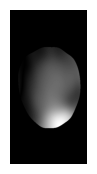

In [21]:
print(sens_maps.shape)
fig = plt.figure(figsize=(1,2))
ax = fig.add_subplot(111)
ax.imshow(np.abs(sens_maps[0, :, :, 0]),'gray')
ax.axis('off')

$\operatorname{S}_i f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)$

In [29]:
sens_maps = sens_maps.to(device)

output_sens_image = complex_mul(output_image, sens_maps)
output_sens_image.shape

torch.Size([20, 640, 320, 2])

$\operatorname{FS}_i f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)$

In [35]:
Fimg = fft2c(output_sens_image)
Fimg.shape

torch.Size([20, 640, 320, 2])

$\operatorname{M}$

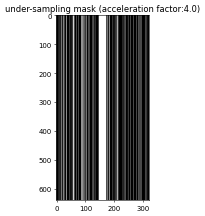

In [36]:
mask_mtx = np.tile(np.array(input_mask.squeeze(0).squeeze(0).squeeze(1)), (target_kspace.shape[1], 1))
plt.figure(dpi=50)
plt.imshow(mask_mtx,'gray')
plt.title('under-sampling mask (acceleration factor:{})'.format(np.round(mask_mtx.shape[1]/np.sum(mask_mtx[0]),2)))
plt.show()

In [37]:
input_mask = input_mask.to(device)
input_mask.shape

torch.Size([1, 1, 320, 1])

$\mathbf{A} f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right) = \operatorname{MFS}_i f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)$

In [38]:
Fimg_forward = Fimg * input_mask
Fimg_forward.shape

torch.Size([20, 640, 320, 2])

$\mathbf{y}_i$

In [39]:
input_kspace = input_kspace.to(device)
input_kspace.shape

torch.Size([20, 640, 320, 2])

$\frac{\left\|\mathbf{y}_i-\mathbf{A} f_{\boldsymbol{\theta}}\left(\mathbf{A}^{\dagger} \mathbf{y}_i\right)\right\|_1}{\left\|\mathbf{y}_i\right\|_1}$

In [40]:
l1_loss = torch.nn.L1Loss(reduction='sum')
loss_self = l1_loss(Fimg_forward, input_kspace) / torch.sum(torch.abs(input_kspace))

In [41]:
loss_self

tensor(1.1966, device='cuda:0', grad_fn=<DivBackward0>)

In [25]:
input_image = input_image.to(device)
input_image.shape

torch.Size([2, 640, 320])

In [26]:
torch.moveaxis( model(input_image.unsqueeze(0)) , 1, -1 ).shape

torch.Size([1, 640, 320, 2])

In [27]:
input_kspace.shape

torch.Size([20, 640, 320, 2])

### Scaling function
The under-sampled $k$-space input is scaled such that the norm of output image is close to the norm of the input image. 

In [28]:
def scale_factor(input_image, input_kspace, model):
    # input_image: [2,320,320]

    for k in range(5):
        # output = [1,640,320,2]
        output_image = torch.moveaxis( model(input_image) , 1, -1 ) 

        if k == 0:
            input_kspace_scale = input_kspace * torch.norm(output_image.detach()) / torch.norm(input_image.detach())
        else:
            input_kspace_scale *= torch.norm(output_image.detach()) / torch.norm(input_image.detach())
        
        input_image = torch.moveaxis( rss_complex(ifft2c(input_kspace_scale))[None,:] , -1, 1 )

        scale = (torch.norm(input_kspace_scale) / torch.norm(input_kspace)).data.cpu().numpy()[np.newaxis][0]
    return scale